# Convective fit all
averaged over the last portion of the simulation



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Try Bachman approach
# Assuming v' ` h/H V_int
def fitH(factor, C):
    nt = factor.size
    h = np.zeros((nt))
    #C = 90
    for i in range(0, nt):
        alpha = (C)**3*factor #Bek[i]**2/(H[i]*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
        p = -3/8*alpha**2 - 3*alpha
        q = 1/8*alpha*((alpha-2)**2 +20)
        Q = ((27*alpha**2 + np.sqrt(729*alpha**4+6912*alpha**3))/2)**(1/3)
        S = 1/2*np.sqrt(2*alpha + 1/4*alpha**2 + 1/3*(Q-12*alpha/Q))
    
        x1 = -alpha/4-S+1/2*np.sqrt(-4*S**2-2*p+q/S)
    
    #h[i] = x1*H[i]
#h[h<0] = np.nan
    return (x1)

In [55]:
def fitn(ent, Htotal):
    def fitHN(factor, C):
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            poly = np.zeros((5,))
            poly[0] = 1
            poly[1] = -C**3*factor[i]*ent[i]**3
            poly[2] = C**3*3*factor[i]*ent[i]**2
            poly[3] = -C**3*3*factor[i]*ent[i]
            poly[4] = C**3*factor[i]
            
            def f(x):
                #return poly[0]*x**4 + poly[1]*x**3 + poly[2]*x**2 + poly[3]*x + poly[4]
                return x**4 - C**3*factor[i]*(1-ent[i]*x)**3
#                 return x**2 - C*factor[i]*(1 - ent[i]*x)
            
            if np.isfinite(factor[i]):
                roots = np.roots(poly)
                sol = optimize.root(f, [0, 1], method='lm',options= {'maxfev':10000, 'maxiter':1000, 'ftol':0.0001})
#                 print(sol)
                if not sol.success:
                    print('fail')
    #                     h[i] = np.nan
                    print(sol)
                    ind = np.where(imag(roots)==0)
                    if size(ind)>0:
                        roots = real(roots[ind])
                        roots = np.sort(roots)
                        h[i] = roots[0]
                #print('here' + str(sol.x))
                else:
                    h[i] = (np.sort(sol.x)[0])
#                     h[i] = sol.x
                #h[i] = real(roots[-1])
                #print(roots)

        #h[h<0] = np.nan
        return h*Htotal
    return fitHN

In [517]:
def fitnH(ent, H):
    return fitn(ent)*H

In [ ]:
fitn(enttotal)(factor, popt[0])


In [73]:
#%% Pick the filename and path
files = [#'/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_s4.h5', 
         '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5', 
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5',
         #'/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_old.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5',
         #'/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5',
#          '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p01/snapshots/snapshots_1e-7_0p01.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'
        ]

molec = 0

factor = []
ydata = []
hntotal = []
Htotal = []
vbf = []
vpwp = []
vpwpscale = []
enttotal = []
vpwpa = []
vbfa = []
test = []
flagfirst = True
for filename in files:
    print(filename)
    f = h5py.File(filename, 'r')
    print('Loaded')
    # Get the data
    data = list(f['tasks'])

    # Basic parameters
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'] # Slope angle


    # Load variables in physical space
    b = f['tasks']['b'] # Perturbation buoyancy
    v = f['tasks']['v'] # Along-slope direction
    vbfr = f['tasks']['VBFrotated']
    GSP = f['tasks']['GSProtated'][:,:,:]*1e-4/(N**2*np.sin(tht[0,0,0]))
    #vbfrot = f['tasks']['VBFrotated']
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    q = f['tasks']['PV']
    wq = f['tasks']['wq']
    print('Begin calcs')
    qm = np.mean(q, axis=1)
    Qo = 1e-4*N**2
    vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
    bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
    # Calculate BEk
    tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
    Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])

    # Calculate h
    print('Calculations Complete')
    
    nt = time.size
    avgt = 12
    for i in range(1, nt-avgt+1, avgt):
        ti = range(i, i+avgt)
        vsmooth = np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:] + N**2*np.cos(tht[0,0,0])), axis=0)
        #inds = np.where(np.diff(np.sign(vsmooth)) <0)[0]
        #inds = np.where(vsmooth>0)[-1] # shallowest point where w'b'>0

        qsmooth = integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)/z
        qmean = np.mean(qm[ti,:], axis=0) #direct Q
        
        # Try a direct calculation of H and entrainment
#             indq = np.where(np.mean(qm[ti,:], axis=0)>(0.*Qo))[0][0]
        indq = np.where(qmean<0.25*1e-4*1e-7)[0][-1] 
        indq = np.where(qmean<0.25*Qo)[0][-1] 

    #         indq = np.where(np.logical_and(np.mean(wq[ti,0,:], axis=0)>=0, z>10))[0][0]
        H = z[indq]
        ent = np.mean(vbfr[ti,0,indq] - 1e-4*(bz[ti,indq] + N**2*np.cos(tht[0,0,0])))
        
        #indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
        #inds = np.where(inds<=indq)[0]
        inds = np.where(np.logical_and(vsmooth>0, z<=H))[0]

        if inds.size == 0:
            print('No Ind: ' + filename)
        else:
            inds = [inds[-1]]
            #test = 1
            hn = z[inds[0]]

            S2 = N**2*np.tan(tht[0,0,0])**2/1e-8
            Beka = np.mean(Bek[ti])
            Ha = H
            ha = hn
            factorPartial = (1+S2)*Beka**2/(Ha*0.1**3)*(1e-4/(N**2*np.tan(tht[0,0,0])))**3 # v' ~ V h/H
#             factorPartial = Beka*1e-4/(0.1**2*N**2*np.tan(tht[0,0,0]))
            ydataPartial = ha/Ha     
            entPartial = 1 + ent/Beka 

#             valt = hn*(1e-4*S2/np.tan(tht[0,0,0])/(1+S2))
            valt = 0.1
#             valt = np.mean(np.sqrt(np.abs(tauy[ti])/1030))
            vpwp.append(np.mean(GSP[ti,0,inds[0]]-0*1e-4*vz[ti,inds[0]], axis=0))
            vpwpscale.append((-Beka*ha/(1+S2))**(1/3)*valt)
            enttotal.append(entPartial)
            factor.append( factorPartial)
            ydata.append(ydataPartial)
            hntotal.append(ha)
            Htotal.append(Ha)
            vpwpa.append(np.mean(GSP[ti,0,:], axis=0)*N**2*np.sin(tht[0,0,0])/1e-4)
            vbfa.append(np.mean(vbfr[ti,0,:], axis=0))
#             test.append(Beka/(N**2*tht[0,0,0]*(-Beka*Ha)**(1/3)*0.1/1e-4 - Beka))
            test.append(np.sqrt(np.abs(np.mean(tauy[ti]))/1030))
#             indq = np.where(np.mean(wq[ti,0,:])>0)
            if flagfirst:
                vbf = np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]+N**2*np.cos(tht[0,0,0])), axis=0)[:,np.newaxis]
                flagfirst = False
            else:
                vbf = np.concatenate((vbf,np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]+N**2*np.cos(tht[0,0,0])), axis=0)[:,np.newaxis]), axis=-1)
    f.close()

factor = np.array(factor)
ydata = np.array(ydata)
hntotal = np.array(hntotal)
Htotal = np.array(Htotal)

/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5
Loaded
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5
Loaded
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5
Loaded
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5
Loaded
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p01/snapshots/snapshots_1e-7_0p01.h5
Loaded
Begin calcs
Calculations Complete
No Ind: /data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p01/snapshots/snapshots_1e-7_0p01.h5
No Ind: /data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p01/snapshots/snapshots_1e-7_0p01.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5
Loaded
Begin calcs
Calculations Complete
No Ind: /data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snap

0.0007844291573655738


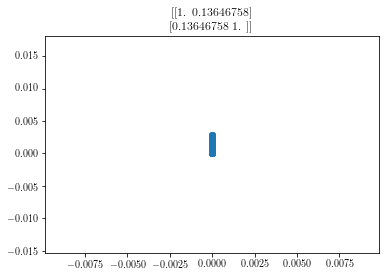

In [68]:
plt.figure()
num = np.array(vpwp)**(1)
scale = (np.array(vpwpscale)*ydata**(1))**(1)/190
# scale = (np.array(vpwpscale)*ydata**(-2/3))**(1)
# scale = (ydata**2*0.1**2)/3000
scale = (ydata**(1)*np.array(test)**1)
plt.scatter(num, scale)
# plt.plot(num, num)
corr = np.corrcoef(num, scale)
plt.title(corr**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(scale, num)
xl = 1e-5*2
# plt.ylim(-xl, xl)
# plt.xlim(-xl, xl)
print(slope)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: OptimizeWarning: Unknown solver options: maxfev


196.94647692958955
[[1.         0.82977873]
 [0.82977873 1.        ]]


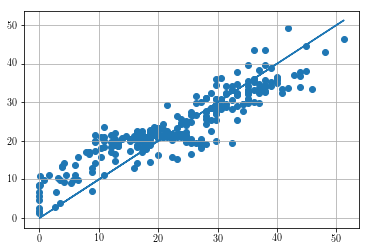

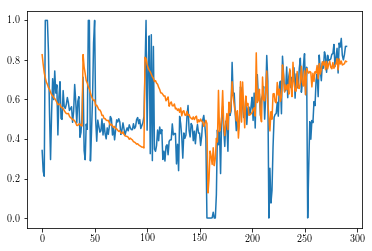

In [75]:
# fit optimal in terms of h (rather than h/H)
# poptl, pcov = optimize.curve_fit(fitH, factor[:], ydata[:]*Htotal, p0=14)
# print(poptl[0])

mask = ydata<100
en = np.array(enttotal)
popt, pcov = optimize.curve_fit(fitn(en[mask], Htotal[mask]), factor[mask], ydata[mask]*Htotal[mask], p0=14)
print(popt[0])

print(np.corrcoef(np.array(hntotal), y = fitn(en, Htotal)(np.array(factor), popt[0]))**2)
# plt.scatter(np.array(hntotal)/np.array(Htotal), fitH(np.array(factor), poptl[0]))
fitt = fitn(en, Htotal)(np.array(factor), popt[0])
plt.scatter(np.array(hntotal), fitt)


plt.plot(np.array(hntotal), np.array(hntotal))

plt.grid()
plt.figure()
plt.plot(ydata)
plt.plot(fitt/Htotal)

# plt.plot(fitH(factor, poptl[0]))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: OptimizeWarning: Unknown solver options: maxfev


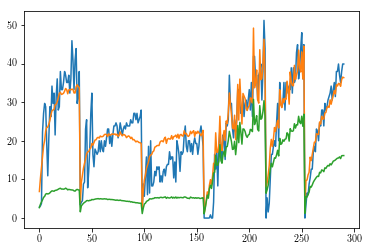

In [77]:
plt.figure()
plt.plot(ydata*Htotal)
plt.plot(fitn(en, Htotal)(factor, popt[0]))
plt.plot(fitn(en, Htotal)(factor, 14))


In [ ]:

#plt.xlim((0, 2))
#plt.ylim((0, 2))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: OptimizeWarning: Unknown solver options: maxfev


(-1e-09, 1e-09)

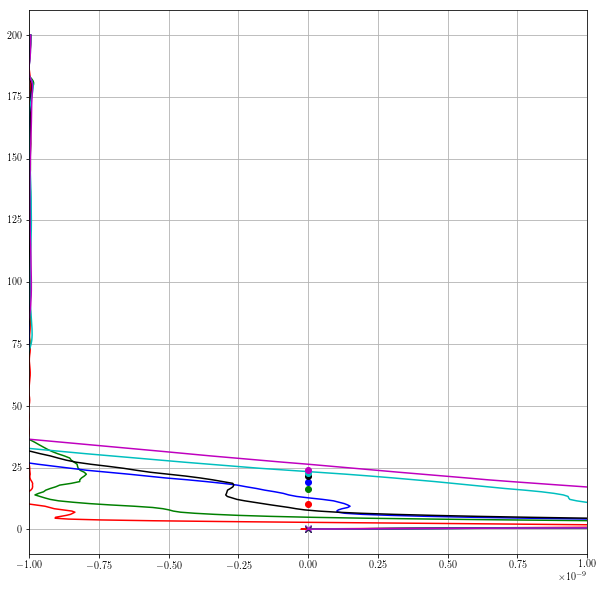

In [905]:
nz, nf = np.array(vbf).shape
colors = ['r', 'g', 'b', 'k', 'c', 'm']
plt.figure(figsize=(10,10))
for i in range(0, size(colors)):
    plt.plot(vbf[:,i], z, color=colors[i])
    plt.plot(0, ydata[i], color=colors[i], marker='x')

    #    plt.plot(0, fitH(factor[i], popt[0]), marker='x', color=colors[i])
    plt.plot(0, fitn(np.array([enttotal[i]]), Htotal[i])(np.array([factor[i]]), popt[0]), marker='o', color=colors[i])

plt.grid()   
# plt.ylim((0, 1))
plt.xlim((-1e-9, 1e-9))

In [ ]:
test.shape

In [ ]:
vbf

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: OptimizeWarning: Unknown solver options: maxfev


(-2e-10, 2e-10)

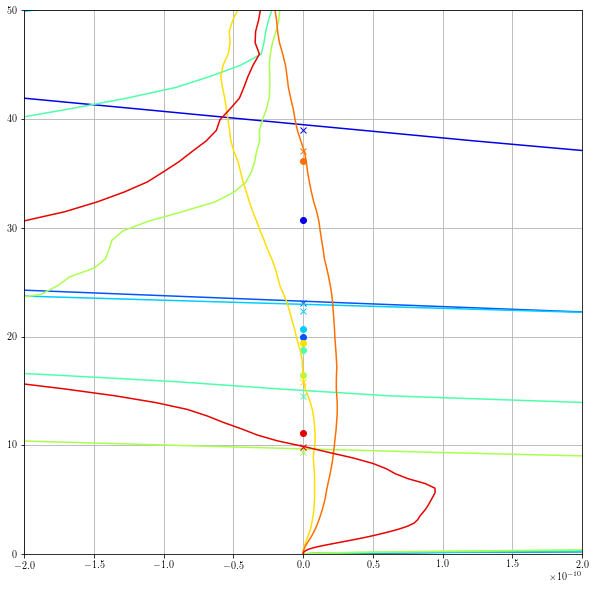

In [923]:
nz, nf = np.array(vbf).shape
colors = ['r', 'g', 'b', 'k', 'c', 'm', 'r', 'g', 'b']
plt.figure(figsize=(10,10))
for i in range(8, nf, 10):
    plt.plot(vbf[:,i], z, color=plt.cm.jet(i/nf))
    #plt.plot(0, fitH(factor[i], popt[0]), marker='x')
    plt.plot(0, fitn(np.array([enttotal[i]]), Htotal[i])(np.array([factor[i]]), popt[0]), marker='o', color=plt.cm.jet(i/nf))
    plt.gca().set_prop_cycle(None)
    plt.plot(0, ydata[i]*Htotal[i],  marker='x',color=plt.cm.jet(i/nf))

plt.grid()   
plt.ylim((0, 50))
plt.xlim((-2e-10, 2e-10))
#lt.xlim((-1e-9, 1e-9))

In [ ]:

#plt.plot(fitH(factor, popt[0]))

## Test one specific run

In [ ]:
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5' #Ruan case F
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
b = f['tasks']['b'] # Perturbation buoyancy
v = f['tasks']['v'] # Along-slope direction
vbfr = f['tasks']['VBFr']
#vbfrot = f['tasks']['VBFrotated']
z = v.dims[2][0][:]
time = v.dims[0][0][:]
q = f['tasks']['PV']
qm = np.mean(q, axis=1)
Qo = 1e-4*N**2
vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
# Calculate BEk
tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])

# Calculate h

nt = time.size

h_H = []
Hq = []
x1 = []
for i in range(0, nt, 12):
    ti = range(i, i+12)
    vsmooth = np.mean(vbfr[ti,0,:]-0*1e-4*(bz[ti,:] + N**2), axis=0)
    #inds = np.where(np.diff(np.sign(vsmooth)) <0)[0]
    #inds = np.where(vsmooth>0)[-1] # shallowest point where w'b'>0

    qmean = integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)
    #indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
    #inds = np.where(inds<=indq)[0]
    inds = np.where(np.logical_and(vsmooth>0, qmean<=0))[0]
    if inds.size == 0:
        inds = [0]
    inds = [inds[-1]]
    
    hn = z[inds[0]]
# Calculate H
    nt = Bek.shape[0]

   

    # Try a direct calculation of H and entrainment
    indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
    H = z[indq] - z[0]
    ent = np.mean(vbfr[ti,0,indq] - 1e-4*(bz[ti,indq] + N**2))

    Beka = np.mean(Bek[ti])
    Ha = H
    ha = hn
    factorPartial = Beka**2/(Ha*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
    ydataPartial = ha/Ha     
    entPartial = 1 + ent/Beka
    
    h_H.append(ydataPartial)
    Hq.append(Ha)
    x1.append(fitn(np.array([entPartial]))(np.array([factorPartial]), popt[0]))
    
x1 = np.array(x1)
h_H = np.array(h_H)
Hq = np.array(Hq)

In [ ]:
x1.append(fitn(np.array([entPartial]))(np.array([factorPartial]), popt[0]))

In [ ]:
plt.plot(h_H*Hq)
plt.plot( x1[:,0]*Hq)

In [ ]:
x1.shape

In [ ]:
Hq.shape

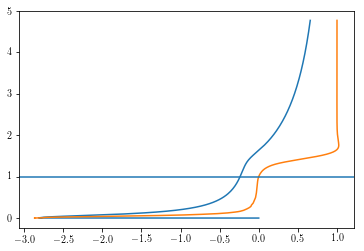

In [968]:
plt.plot(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)/z/Qo, z/Ha)
plt.plot(np.mean(qm[ti,:], axis=0)/Qo, z/Ha)
plt.axhline(z[indq]/Ha)

# plt.xlim(-2, 2)

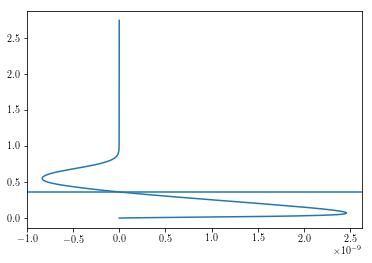

In [958]:
plt.plot(vsmooth, z/Ha)
plt.axhline(z[inds[0]]/Ha)

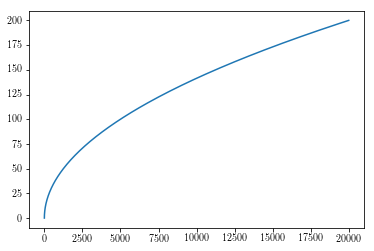

In [310]:
plt.plot(integrate.cumtrapz(z, x=z, initial=z[0]), z)

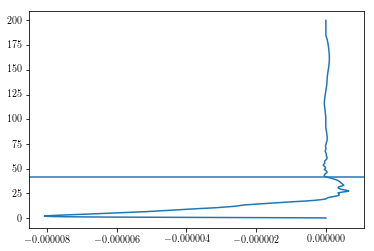

In [647]:
plt.plot(np.mean(GSP[ti,0,:], axis=0), z)
# plt.plot(np.mean(vbf))
plt.axhline(z[inds[0]])

In [959]:
ts= 20
plt.plot(vpwpa[ts], z)
plt.plot(vbfa[ts], z)

plt.axhline(Htotal[ts], color='g')
plt.axhline(ydata[ts]*Htotal[ts])
plt.axhline(fitn(np.array([enttotal[ts]]), Htotal[ts])(np.array([factor[ts]]), popt[0]), color='r')
plt.ylim(0, 90)

IndexError: list index out of range

Text(0.5,1,'[[ 1.        -0.5824891]\n [-0.5824891  1.       ]]')

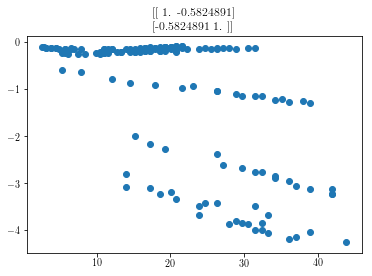

In [861]:
plt.scatter(ydata*Htotal, np.array(test)*Htotal)
plt.title(np.corrcoef(ydata, np.array(test)))

In [982]:
plt.plot(np.mean(wq[ti,0,:]-0*1e-4*np.gradient(qm[ti,:], axis=-1)/np.gradient(z), axis=0), z/Ha)

ValueError: Not a dataset (Not a dataset)

In [942]:
q.shape

(720, 1024, 256)

In [943]:
qm.shape

(720, 256)

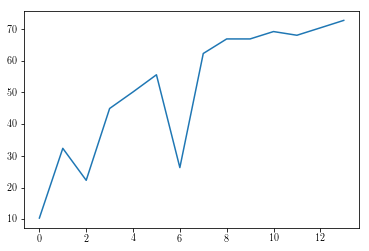

In [963]:
plt.plot(Htotal)

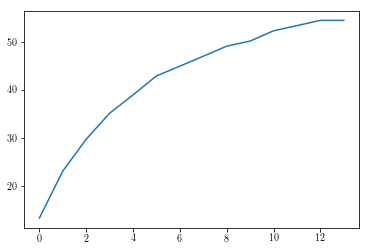

In [972]:
plt.plot(Htotal)